# Including Libraries

In [158]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

import time

import importlib
import utils

importlib.reload(utils)
from utils import (
    accuracy,
    train,
    test,
    plot_acc,
    plot_loss,
    plot_confusion_matrix,
    save_model,
    get_feature_maps,
    visualize_feature_maps,
    plot_images,
)

# Loading CIFAR10 + Preprocess

In [130]:
class OneHotEncode:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, label):
        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [18]:
train_size = 50000

val_size = 10000

test_size = 10000


torch.manual_seed(13)
np.random.seed(13)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


label_transform = OneHotEncode(num_classes=2)


train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    target_transform=label_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
    target_transform=label_transform
)

Files already downloaded and verified
Files already downloaded and verified


### Extracting <kbd>airplane</kbd> and <kbd>automobile</kbd>

In [19]:
classes = train_dataset.classes
automobile_index = train_dataset.class_to_idx['automobile']
airplane_index = train_dataset.class_to_idx['airplane']


print(classes)
print(f"automobile: {automobile_index}")
print(f"airplane: {airplane_index}")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
automobile: 1
airplane: 0


In [20]:
indices = [airplane_index, automobile_index]

train_indices = np.where(np.isin(train_dataset.targets, indices))[0]
test_indices = np.where(np.isin(test_dataset.targets, indices))[0]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_subset, val_subset = random_split(train_subset, [0.8, 0.2])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=True)

# 1) Cross Entropy Loss

## a) Loading pre-trained model + training model


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(f'device: {device.type}')

device: cpu


In [32]:
num_classes = 2

model = resnet50(weights=ResNet50_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [34]:
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters())

## b) training model

In [37]:
start_time = time.time()


epochs = 2


train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log=True,
)


end_time = time.time()


print(f"time: {np.round(end_time - start_time, 2)} seconds")

hezllo
time: 378.57 seconds


## c) plotting Loss and Accuracy

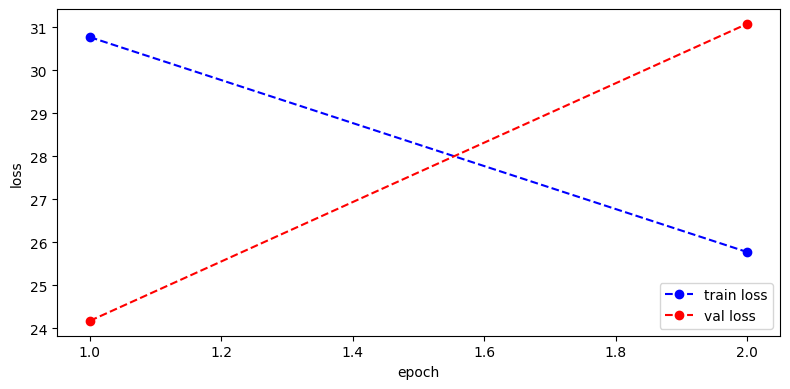

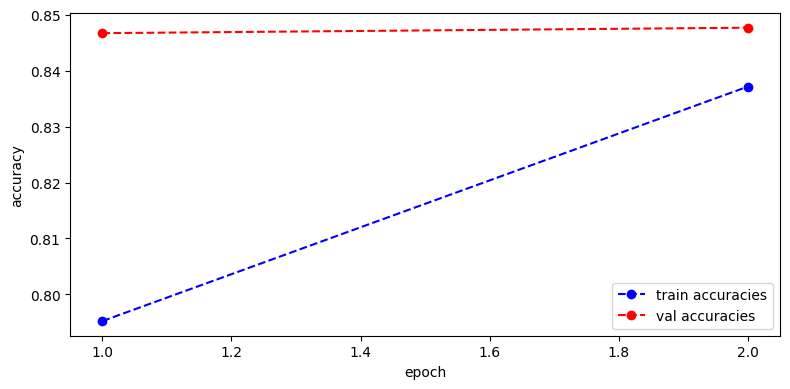

In [38]:
plot_loss(train_losses, validation_losses, epochs=epochs)


plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

## d) plotting Feature Maps during training

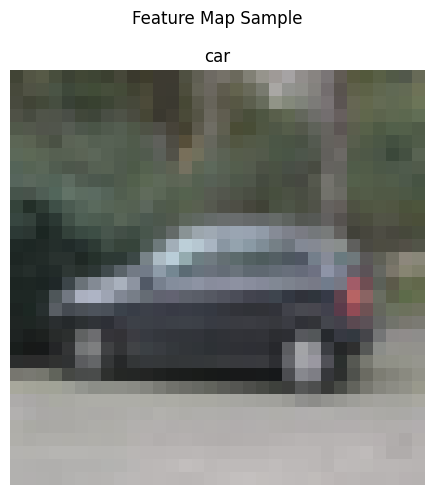

feature map size: torch.Size([1, 256, 8, 8])


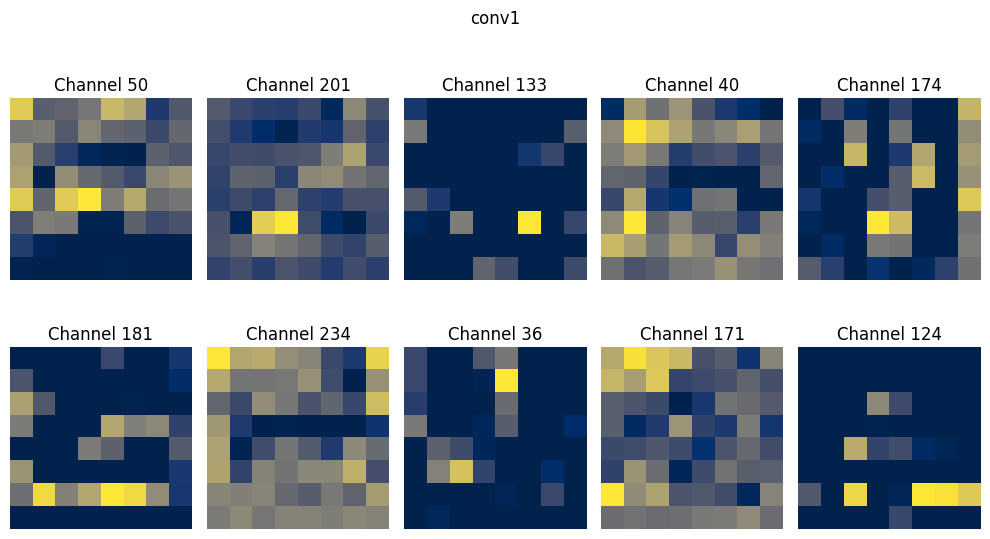

feature map size: torch.Size([1, 256, 8, 8])


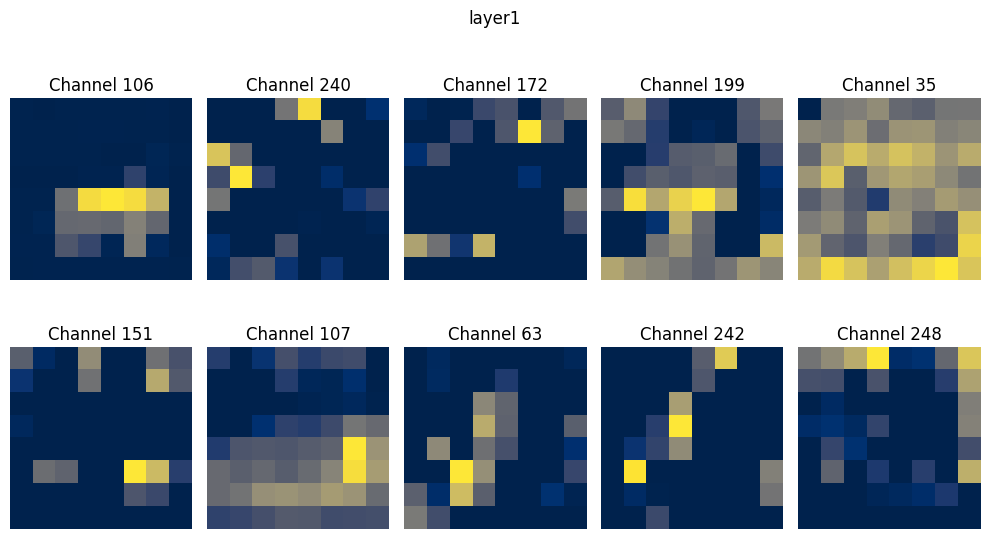

feature map size: torch.Size([1, 256, 8, 8])


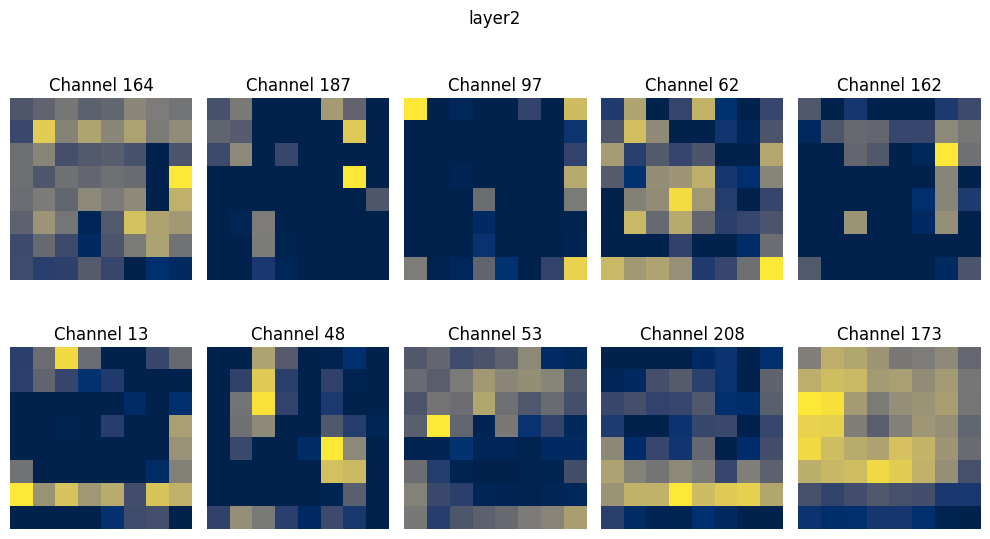

feature map size: torch.Size([1, 256, 8, 8])


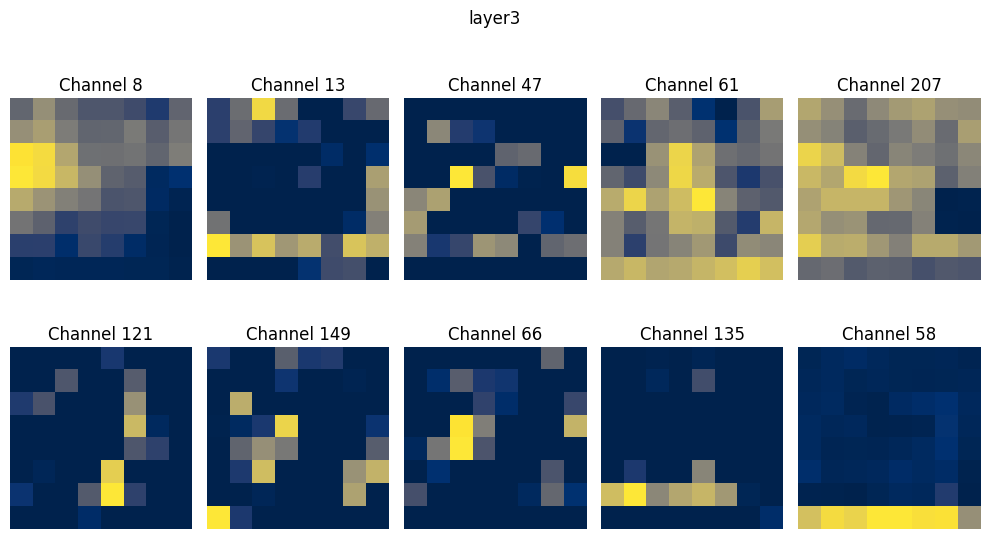

In [165]:
images, labels = next(iter(train_loader))
image, label = images[0], 'airplane' if labels[0, 0].item() else 'car'

plot_images([image], [label], title='Feature Map Sample')

layers = ['conv1', 'layer1', 'layer2', 'layer3']

for layer in layers:
    feature_map = get_feature_maps(model, 'layer1', image)
    print(f'feature map size: {feature_map.shape}')
    visualize_feature_maps(feature_map, title=layer, num_maps=10)